##This is a complete code for fine tuning LAMMA 2 model on a custom dataset

installing required dependencies

In [2]:
!pip install -q accelerate==0.21.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.9 MB/s eta 0:00:00


In [6]:
!pip install transformers==4.31.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7

  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
!pip install fsspec==2024.10.0 sentence-transformers==2.2.2




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 6.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=8cc6f4ad807c91dc60760626acab459955e257f902be1b0f514add1ef7d5417b
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.3.1
    Uninstalling sentence-transformers-3.3.1:
      Successfully uninstalled sentence-transformers-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [16]:
from datasets import load_dataset

In [7]:
import os
import torch
from transformers import (
    AutoModelForCausalLM , #to load llm
    AutoTokenizer,# for tokenization
    BitsAndBytesConfig,  # for quantization configuaration
    HfArgumentParser, #making LLm scripts configurable
    TrainingArguments, # provide interface for parameters like batch size , learnng rat etc
    pipeline, # simpllifies running interface
    logging,# manage logging configuration
)

 # peft model for wrapping model to apply lora fine tuning
from peft import LoraConfig, PeftModel
from trl import SFTTrainer


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


**The Prompt templete of llama model is defined as **-

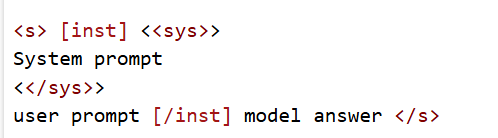

original dataset link - [https://www.google.com/url?q=https%3A%2F%2Fhuggingface.co%2Fdatasets%2Ftimdettmers%2Fopenassistant-guanaco](https://)

reformatted dataset based on llama template - [https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k](https://)

WE will use parameter efficient fine tuning tecniques here(LORA , QLORA ) as we have a resource constraint and full fine tuning can not happen here

###STEP 1 - we need to load the llama model here 1st

In [17]:
## these are data and model parameters '
## we are only using 1k part dataset to ensure the machine can handel this
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset in use - this is transfromed onto the llama specific prompt template for learning
dataset_name = "mlabonne/guanaco-llama2-1k"

# Final Fine-tuned model name will be this
new_model = "Llama-2-7b-chat-finetune_milan"

In [18]:

use_4bit = True #convert model parameters to 4bit

bnb_4bit_compute_dtype = "float16" # in 4bit quantizationn , weights are stored in 4bit
# but during training , operations (like matrix multiplication) must use higher  precision to avoid numerical instability


bnb_4bit_quant_type = "nf4"  # its a quantization format (normal float 4bit)

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False # we dont need this here

In [19]:
dataset = load_dataset(dataset_name, split="train") # only training protion of data is being loaded here

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)  # this enables flexibility to specify the compute precision

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

README.md:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

(…)-00000-of-00001-9ad84bb9cf65a42f.parquet:   0%|          | 0.00/967k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

 **what we have done upto yet**
*   loaded the dataset(custom) only 1k rows
*   bnb configuration ensures - base model is loaded into memory using 4bit quantized weights

*   even though weights are stored in 4bit , operations (like backprop) performed on float16 (for accuracy)



In [13]:
import torch

if torch.cuda.is_available():
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    print("No GPU available. Using CPU.")


No GPU available. Using CPU.


## needs to be connected to a GPU for the next tasks

In [25]:
## loading the base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    device_map = 'auto' #use 'auto' if youre working upon your own device , this is for T4 gpu

)

model.config.use_cache = False #caching improves efficiency during inference
# but in fine tuning can lead to excessive memory consumption

model.config.pretraining_tp = 1
 # set tensor parallelism = 1 means no parallel splitting


In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
#trust remote code allows downloading
## its necessary for models that use special tokenization logic
tokenizer.pad_token = tokenizer.eos_token
#padding is required for processing batches of sequence with different lengths
# ensures compatibility
tokenizer.padding_side = "right" # padding should be at the right side

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

#next step is to specify LORA parameters

In [11]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)


In [12]:
training_arguments = TrainingArguments(
    output_dir='./sample_data',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1, # specifies the number of steps
    # to accumulate gradients before performing an optimizer step
    optim='paged_adamw_32bit',
    save_steps=0, # intervals at which model checkpoints are saved
    logging_steps=25, # help monitor training process
    learning_rate= 2e-4,
    weight_decay=0.001, ## adds L2 regularization to prevent overfitting
    fp16=False,
    bf16=False,
    max_grad_norm= 0.3,  #clips gradients to this max norm , prevent exploding gradient
    max_steps= -1 , # limits total number of training steps
    warmup_ratio= 0.03,
    group_by_length= True,  # groups training samples by length
    lr_scheduler_type='cosine',  ## controls how learning rate changes
    report_to="tensorboard"  ## to enables vizualization
)

##This is a main final step -


1.   supervised fine tunning using SFTTrainer
2.   parameters need to set in this case too



In [26]:
## Training using SFTtrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
    packing= False ,
)

trainer.train()

## finally save the trained model

In [27]:
## this saved model is Now fine tuned over our custom dataset
trainer.model.save_pretrained(new_model)

## new_model is specified above already
